# Lite-HRNet Inference Notebook

#### Code has been hidden for brevity. Use the button below to show/hide code

In [26]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show/Hide Code"></form>''')

In [1]:
import argparse
import os
import torch
import mmcv
import json

import numpy as np
import cv2
import ipywidgets as widgets

from PIL import Image, ImageFont, ImageDraw
from mmcv import Config
from mmcv.cnn import fuse_conv_bn
from mmcv.runner import load_checkpoint

from models import build_posenet

from IPython.display import clear_output
from ipywidgets import HBox, Label, Layout

In [2]:
from IPython.display import Javascript, display
from ipywidgets import widgets

def run_cells_below(b):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))


In [3]:
VALID_IMG_TYPES = ['jpg','jpeg', 'png']

In [24]:


txt_input_img = widgets.Text(
    value= "../data/ESTEC_Images/image_95.png",
    placeholder="Input image path",
    layout= Layout(width='60%')
    )

HBox([Label('Input image path:'),txt_input_img])
#../data/Envisat+IC1/val2/2000-2999/frame2005.jpg

In [28]:
txt_prefix = widgets.Text(
    value= "image_",
    placeholder="Bounding Box data file",
    layout= Layout(width='60%')
    )

HBox([Label('Filename prefix:'),txt_prefix])

In [29]:


txt_bbox = widgets.Text(
    value= "../data/ESTEC_Images/bbox.txt",
    placeholder="Bounding Box data file",
    layout= Layout(width='60%')
    )

HBox([Label('Bounding box data file:'),txt_bbox])
#../data/Envisat+IC1/val2.json

In [82]:
img_path = os.path.abspath(txt_input_img.value)
bbox_path = os.path.abspath(txt_bbox.value)
inputs= {}

img_name = img_path.split("/")[-1]
img_id= int((img_name.split(txt_prefix.value)[-1]).split('.')[0])  



button = widgets.Button(description="Load Input Image and Data")
output1 = widgets.Output()
output2 = widgets.Output()

display(button, output1, output2)

def load_image_gt(b):

    ## LOAD IMAGE
    with output1:
        print("Loading... This might take a few seconds depending on the image size.")
    with output2:
        
        input_img = Image.open(img_path).convert('RGB')
        inputs['image'] = input_img        

        ## LOAD DATA
        data_ext = bbox_path.split('.')[-1]
        if data_ext.lower() == 'txt':
            bbox_f = open(bbox_path,'r')
            raw_data = bbox_f.readlines()
            this_idx = img_id-14 ## TODO: This is very bad
            
            xyxy = [int(float(v)) for v in (raw_data[this_idx]).split(' ')]
            
            #relax margins for pure bbox in real images
            ext_scale = 0.10 # percent of bbox h/w
            w = abs(xyxy[2]-xyxy[0])
            h = abs(xyxy[3]-xyxy[1])
            
            inputs['bbox'] = [int(xyxy[0]+ (w*ext_scale)), int(xyxy[1]+ (h*ext_scale)), int(xyxy[2]- (w*ext_scale)), int(xyxy[3]-(h*ext_scale))]
            
            box_thickness = 10
        
        elif data_ext.lower() =='json':
            with open(bbox_path, 'r') as jf:
                coco_data = json.load(jf)
            
            coco_anns_idx = {d["id"]:j for j,d in enumerate(coco_data['images'])}
            this_ann = coco_data['annotations'][coco_anns_idx[img_id]]
            
            if this_ann['image_id'] == img_id:
                xyxy = this_ann['bbox']
                inputs['bbox']= [int(xyxy[0]), int(xyxy[1]), int(xyxy[0]+xyxy[2]), int(xyxy[1]+xyxy[3])]
                box_thickness = 2
            
            else:
                Exception("Image ID did not match between annotation and query. There might be a problem with the index map in \"coco_anns_idx\"")
        
        else:
            Exception("Error: Data File Format Invalid")

        ## Visualize GT image/bbox
        vis_img = np.array(input_img)
        xyxy = inputs['bbox']
        cv2.rectangle(vis_img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (255,255,255), box_thickness)
        

        imgvis = Image.fromarray(vis_img, 'RGB')
        display(imgvis)
        

        # RESET CAPTION
        with output1:
            clear_output()
            print(f"Input Image: {img_name}; ID: {img_id}; Bounding box: {xyxy}")

        
    
button.on_click(load_image_gt)

Button(description='Load Input Image and Data', style=ButtonStyle())

Output()

Output()

-------------------

## Initialize Network Model

In [50]:
txt_config = widgets.Text(
    value= "configs/top_down/lite_hrnet/Envisat/litehrnet_18_coco_256x256_Envisat+IC.py",
    placeholder="Config",
    layout= Layout(width='90%')
    )

HBox([Label('Bounding box data file:'),txt_config])

In [51]:

txt_ckpt = widgets.Text(
    value= "work_dirs/litehrnet_18_coco_256x256_Envisat+IC/best/best.pth",
    placeholder="Config",
    layout= Layout(width='90%')
    )
HBox([Label('Bounding box data file:'),txt_ckpt])

In [83]:
from mmpose.apis.inference import LoadImage,_box2cs
from mmpose.datasets.pipelines import Compose
import mmpose.apis.inference as inference_module
from mmcv.parallel import collate, scatter

def new_inference_single_pose_model(model,
                                 img_or_path,
                                 bbox,
                                 dataset,
                                 return_heatmap=False):
    """Inference a single bbox.

    num_keypoints: K

    Args:
        model (nn.Module): The loaded pose model.
        img_or_path (str | np.ndarray): Image filename or loaded image.
        bbox (list | np.ndarray): Bounding boxes (with scores),
            shaped (4, ) or (5, ). (left, top, width, height, [score])
        dataset (str): Dataset name.
        outputs (list[str] | tuple[str]): Names of layers whose output is
            to be returned, default: None

    Returns:
        ndarray[Kx3]: Predicted pose x, y, score.
        heatmap[N, K, H, W]: Model output heatmap.
    """

    cfg = model.cfg
    device = next(model.parameters()).device

    # build the data pipeline
    channel_order = cfg.test_pipeline[0].get('channel_order', 'rgb')
    test_pipeline = [LoadImage(channel_order=channel_order)
                     ] + cfg.test_pipeline[1:]
    test_pipeline = Compose(test_pipeline)

    assert len(bbox) in [4, 5]
    center, scale = _box2cs(cfg, bbox)

    flip_pairs = None
    if dataset == 'TopDownEnvisatCocoDataset':
        flip_pairs = []
    else:
        raise NotImplementedError()

    # prepare data
    data = {
        'img_or_path':
        img_or_path,
        'center':
        center,
        'scale':
        scale,
        'bbox_score':
        bbox[4] if len(bbox) == 5 else 1,
        'dataset':
        dataset,
        'joints_3d':
        np.zeros((cfg.data_cfg.num_joints, 3), dtype=np.float32),
        'joints_3d_visible':
        np.zeros((cfg.data_cfg.num_joints, 3), dtype=np.float32),
        'rotation':
        0,
        'ann_info': {
            'image_size': cfg.data_cfg['image_size'],
            'num_joints': cfg.data_cfg['num_joints'],
            'flip_pairs': flip_pairs
        }
    }
    data = test_pipeline(data)
    data = collate([data], samples_per_gpu=1)
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        # just get the actual data from DataContainer
        data['img_metas'] = data['img_metas'].data[0]

    # forward the model
    with torch.no_grad():
        result = model(
            img=data['img'],
            img_metas=data['img_metas'],
            return_loss=False,
            return_heatmap=return_heatmap)

    return result['preds'][0], result['output_heatmap']

In [92]:

inference_module._inference_single_pose_model = new_inference_single_pose_model


device = 'cuda' if torch.cuda.is_available() else None

config_path = txt_config.value
ckpt_path = txt_ckpt.value
inputs['name'] = img_name
inputs['id'] = img_id
img_data_list_dict = [inputs]

cfg = Config.fromfile(config_path)
model = build_posenet(cfg.model)
load_checkpoint(model, ckpt_path, map_location='cpu')
model = inference_module.init_pose_model(config_path, ckpt_path, device=device)

#gray_img = cv2.cvtColor(np.array(Image.open(img_path)), cv2.COLOR_RGB2GRAY)
#input_img = np.stack((gray_img,)*3, axis=-1)

results, heatmaps= inference_module.inference_top_down_pose_model(model, img_path, img_data_list_dict, return_heatmap=True, format='xyxy', dataset='TopDownEnvisatCocoDataset')


Use load_from_local loader
Use load_from_local loader


In [93]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print('Using device:', device)
#print()'''

In [98]:
%matplotlib inline

#### Single image inference result

In [95]:
hms =heatmaps[0]['heatmap']
result = results[0]
keypoints = ([np.array([v[0],v[1]]) for v in result['keypoints']])
#print(f"Heatmaps array: {np.shape(hms)}")
#print(f"Result: \n Type : {type(result)}\n \n  Keypoints: {keypoints}")

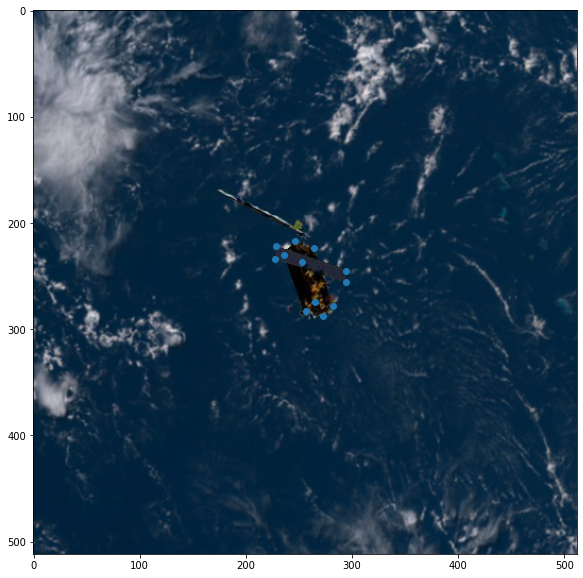

In [96]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(*zip(*keypoints))
plt.imshow(result['image'])
plt.show()

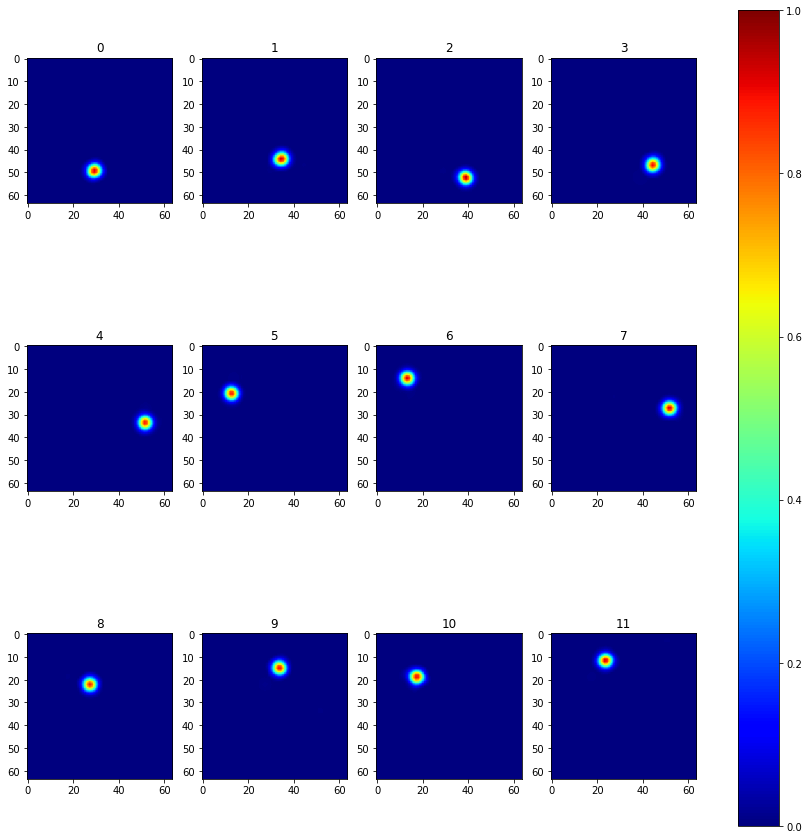

In [97]:
n_hms = np.shape(hms)[1]
f, axarr = plt.subplots(3, 4, figsize=(15,15))
this_col=0
for idx in range(n_hms):
    this_hm = hms[0,idx,:,:]
    row = idx % 4
    this_ax = axarr[this_col, row]
    this_ax.set_title(f'{idx}')
    hm_display = this_ax.imshow(this_hm, cmap='jet', vmin=0, vmax=1)
    if row == 3:
        this_col += 1

f.colorbar(hm_display, ax=axarr)

In [99]:
import random
random.randint(1,10)

1